In [1687]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [953]:
pd.set_option('display.max_columns', None)

In [1354]:
cols = [
    'age', 'wclass', 'industry_c', 'occupation_c',
    'educ', 'wage_ph', 'lw_educ', 'marital_status',
    'major_industry_c', 'major_occupation_c', 'race',
    'hispanic', 'sex', 'union_member', 'unemp_reason',
    'employment_stat', 'cap_gains', 'cap_loss',
    'dividends', 'tax_filer', 'prev_region',
    'prev_state', 'household_stat', 'household_summary',
    'instance_weight', 'msa_change', 'reg_change',
    'reg_move', 'same_house_ly',
    'migration_prev_res', #???
    'num_employed', 'fam_under18', 'father_cob',
    'mother_cob', 'cob', 'citizenship',
    'own_business', 'vet_quiz', 'vet_benefits',
    'weeks_worked_pa', 'year', 'taxable_income'
    ]

In [1355]:
train_data = pd.read_csv('data/census_income_learn.csv', names=cols)
test_data = pd.read_csv('data/census_income_test.csv', names=cols)
all_data = pd.concat([train_data, test_data])

In [1351]:
train_data.head(5)

,age,wclass,industry_c,occupation_c,education,wage_ph,lw_educ,marital_status,major_industry_c,major_occupation_c,race,hispanic,sex,union_member,unemp_reason,employment_stat,cap_gains,cap_loss,dividends,tax_filer,prev_region,prev_state,household_stat,household_summary,instance_weight,msa_change,reg_change,reg_move,same_house_ly,migration_prev_res,num_employed,fam_under18,father_cob,mother_cob,cob,citizenship,own_business,vet_quiz,vet_benefits,weeks_worked_pa,year,taxable_income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


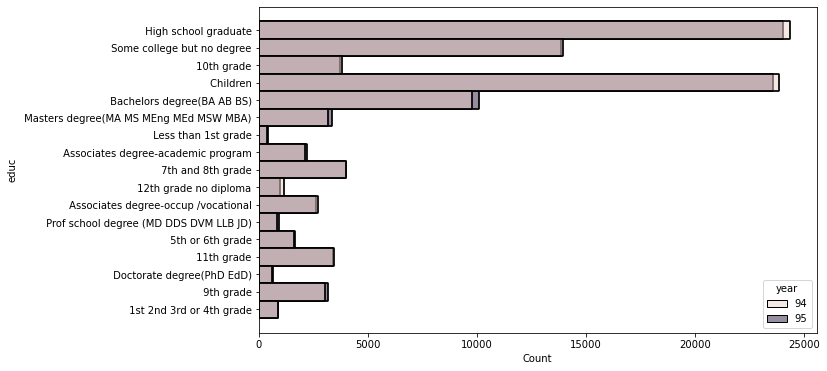

In [1446]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data, y="educ", hue="year")

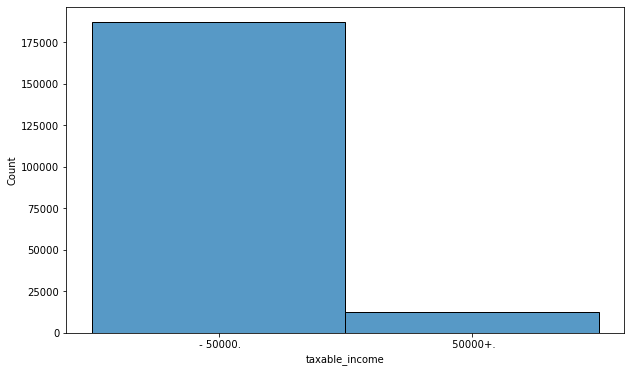

In [1450]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data, x="taxable_income")

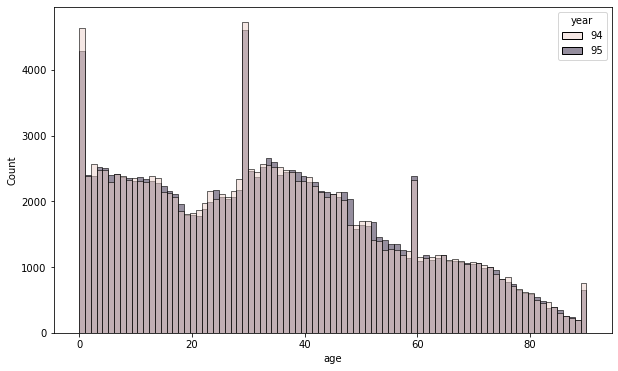

In [1449]:
plt.figure(figsize=(10,6))
sns.histplot(data=all_data, x="age", hue="year")

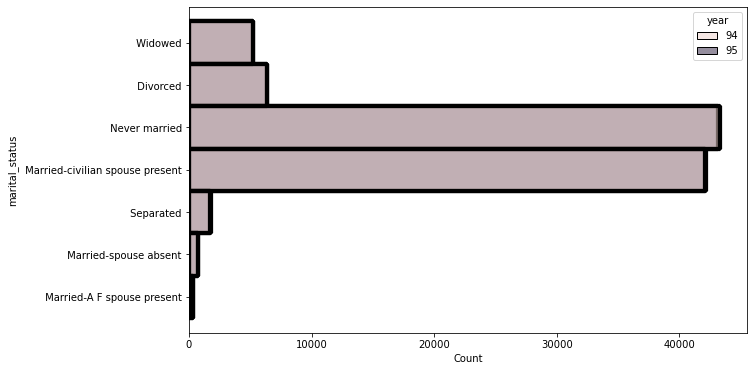

In [959]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data, y='marital_status', hue="year")

In [1227]:
def get_education_level(educ):
    mapping = {
        ' High school graduate': 1,
        ' Some college but no degree': 1, 
        ' Prof school degree (MD DDS DVM LLB JD)': 2,
        ' Associates degree-academic program': 2,
        ' Associates degree-occup /vocational': 2,
        ' Bachelors degree(BA AB BS)': 3,
        ' Masters degree(MA MS MEng MEd MSW MBA)': 4,
        ' Doctorate degree(PhD EdD)': 5       
    }
    if mapping.get(educ):
        return mapping.get(educ)
    else:
        return 0

def is_minority(race):
    return int(race != ' White')

def is_employed(employment):
    return int(employment in [
        ' Private', 
        ' State government', 
        ' Local government', 
        ' Federal government',
        ' Self-employed-incorporated',
        ' Self-employed-not incorporated'
    ])

def is_married(ms):
    return int(ms in [
        ' Married-civilian spouse present', 
        ' Married-A F spouse present', 
        ' Married-spouse absent'
    ])

def is_union_member(x):
    return int(x == ' Yes')

def get_occupation_level(occ):
    mapping = {
        ' Farming forestry and fishing': 1,
        ' Transportation and material moving': 1,
        ' Technicians and related support': 2,
        ' Sales': 2,
        ' Precision production craft & repair': 2,
        ' Professional specialty': 3,
        ' Executive admin and managerial': 3       
    }
    if mapping.get(occ):
        return mapping.get(occ)
    else:
        return 0

def get_industry_level(ind):
    mapping = {
        ' Forestry and fisheries': 3,
        ' Utilities and sanitary services': 3,
        ' Finance insurance and real estate': 3,
        ' Mining': 3,
        ' Armed Forces': 3,
        ' Public administration': 3,
        ' Medical except hospital': 2,
        ' Hospital services': 2,
        ' Transportation': 2,
        ' Business and repair services': 2,
        ' Construction': 1,
        ' Education': 1   
    }
    if mapping.get(ind):
        return mapping.get(ind)
    else:
        return 0

def joint_young_filers(tf):
    return int(tf == ' Joint both under 65')

def is_householder(hs):
    return int(hs == ' Householder')

def is_citizen(c):
    return int(c != ' Foreign born- Not a citizen of U S ')

In [1431]:
def transform_data(df, numeric=False):
    df = df.copy()

    
    bad_cols = [
        'lw_educ', 'hispanic', 'unemp_reason',
        'prev_region', 'prev_state', 'household_stat',
        'msa_change', 'reg_change', 'reg_move', 'migration_prev_res',
        'fam_under18', 'father_cob', 'mother_cob', 'vet_quiz',
        'industry_c', 'occupation_c', 'employment_stat',
        'same_house_ly', 'cob', 'vet_benefits', 'own_business', 
        'instance_weight'
    ]

    redundant_cols = [
        'taxable_income', 'year', 'race',
        'wclass', 'marital_status','sex',
        'union_member', 'major_occupation_c',
        'major_industry_c', 'household_summary',
        'tax_filer', 'citizenship'
    ]
    
    df['educ'] = df['educ'].apply(lambda x: get_education_level(x))
    df['is_minority'] = df['race'].apply(lambda x: is_minority(x))
    df['is_employed'] = df['wclass'].apply(lambda x: is_employed(x))
    df['is_married'] = df['marital_status'].apply(lambda x: is_married(x))
    df['is_female'] = df['sex'].map({' Male': 0, ' Female': 1})
    df['is_union_member'] = df['union_member'].apply(lambda x: is_union_member(x)
                                                    )
    df['occupation_level'] = df['major_occupation_c'].apply(lambda x: get_occupation_level(x))
    df['industry_level'] = df['major_industry_c'].apply(lambda x: get_industry_level(x))
    df['is_householder'] = df['household_summary'].apply(lambda x: is_householder(x))
    df['join_tax_b65'] = df['tax_filer'].apply(lambda x: joint_young_filers(x))
    df['is_citizen'] = df['citizenship'].apply(lambda x: is_citizen(x))
    
    df['wage_ph'] = df.wage_ph * df.instance_weight
    
    df['over50k'] = df['taxable_income'].map({' - 50000.': 0, ' 50000+.': 1})
    
    if numeric:    
        return df[df.columns.drop(bad_cols+redundant_cols)].drop_duplicates()
    else:
        return df.drop_duplicates()

In [1432]:
def cook_data(df, yr=None, numeric=False):
    queries = " & ".join([
        "age != 0"
    ])
    
    filtered_df = df.query(queries)
    if yr:
        filtered_df = filtered_df.loc[filtered_df.year == yr]
        return transform_data(filtered_df, numeric)
    else:
        return transform_data(filtered_df, numeric)

### Creating multiple datasets

In [1617]:
eda_data = cook_data(train_data)
full_data = cook_data(train_data, numeric=True)
data94 = cook_data(train_data, 94, numeric=True)
data95 = cook_data(train_data, 95, numeric=True)

In [1517]:
def get_income_score(df, feature):
    df[feature] = df[feature].astype(str)
    grouping = df.groupby([feature, 'over50k']).size().unstack(fill_value=0).stack().groupby(feature).apply(lambda x: x[1]/sum(x))
    return grouping.reset_index().rename(columns={0:'score'})

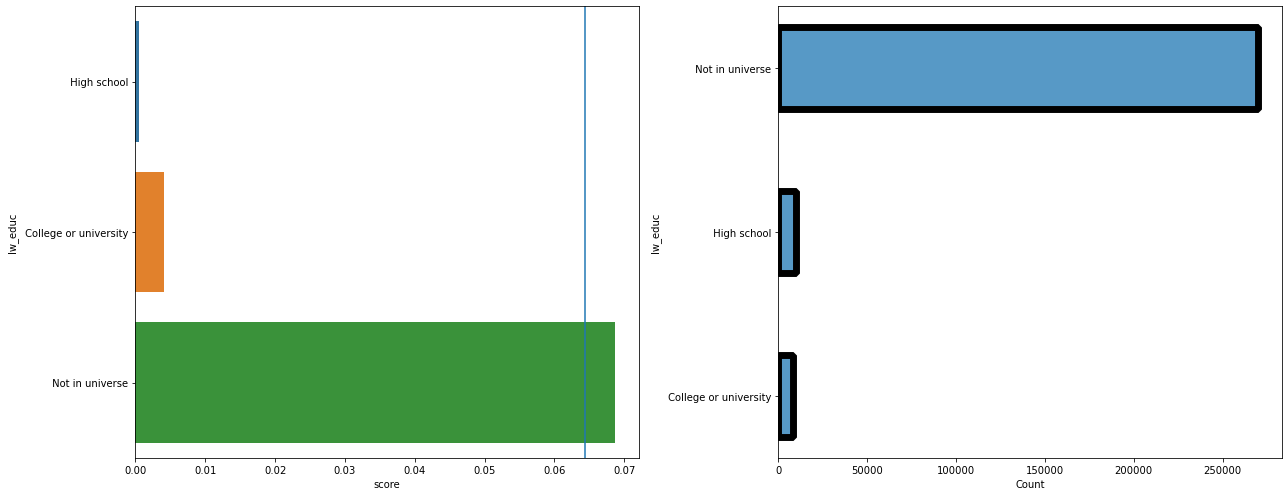

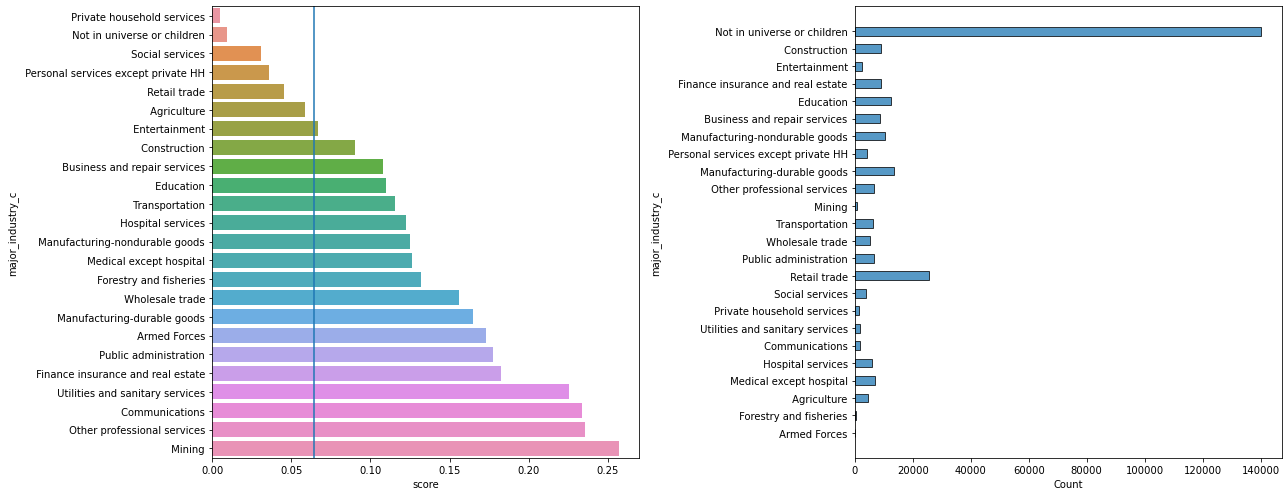

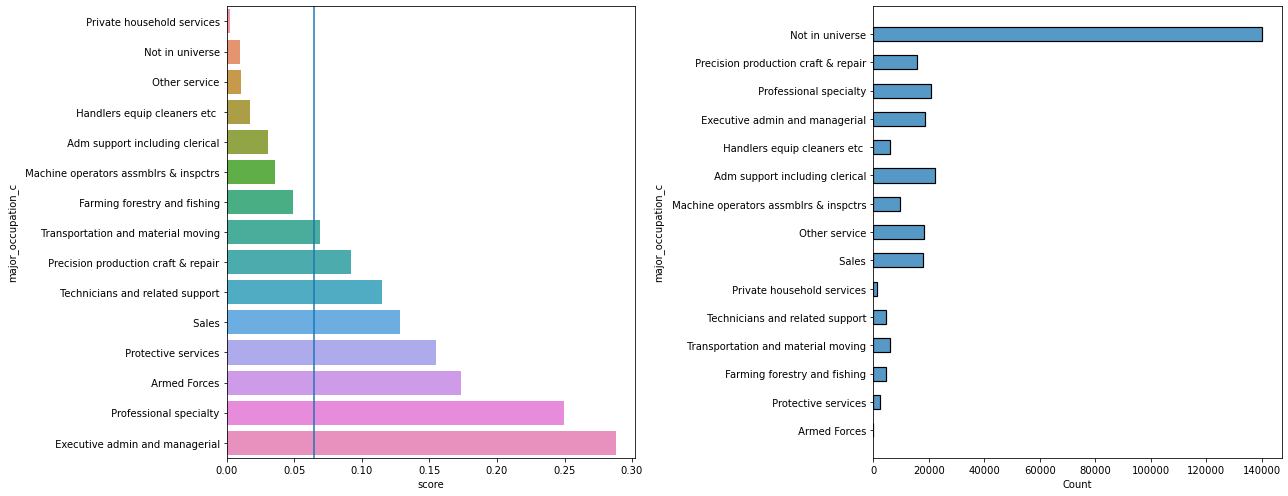

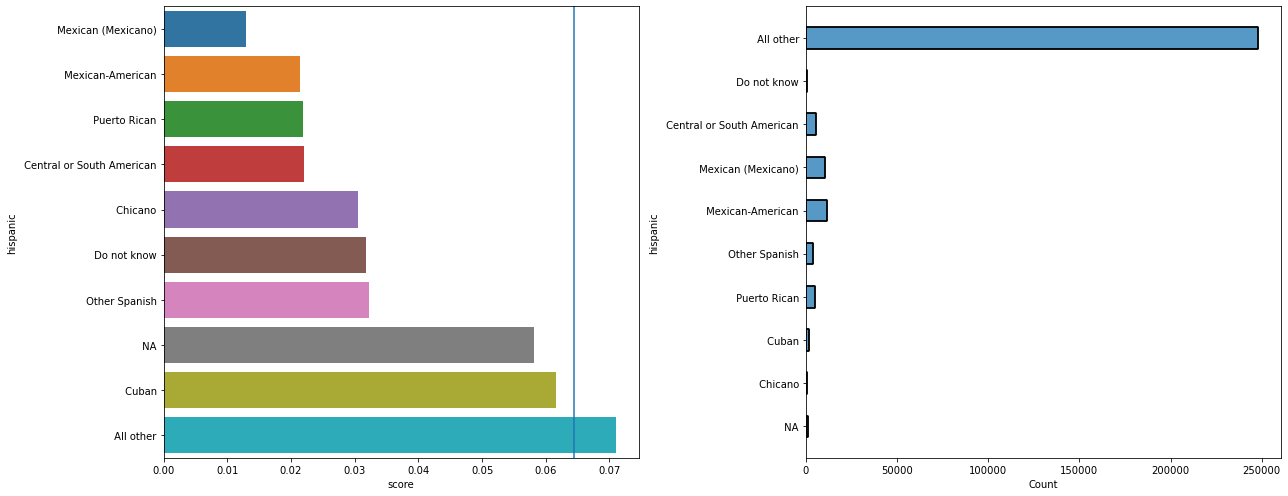

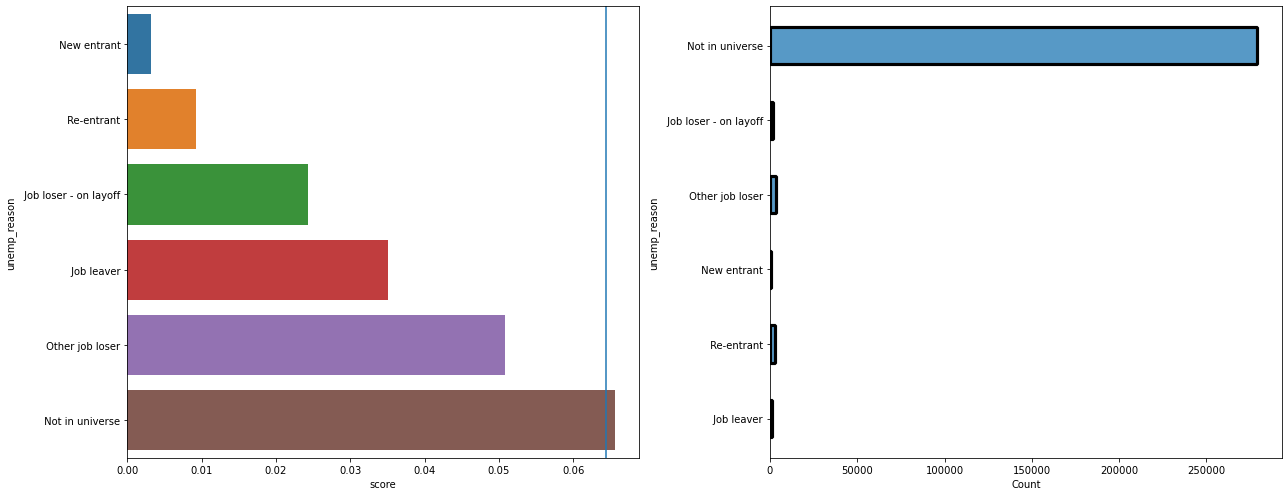

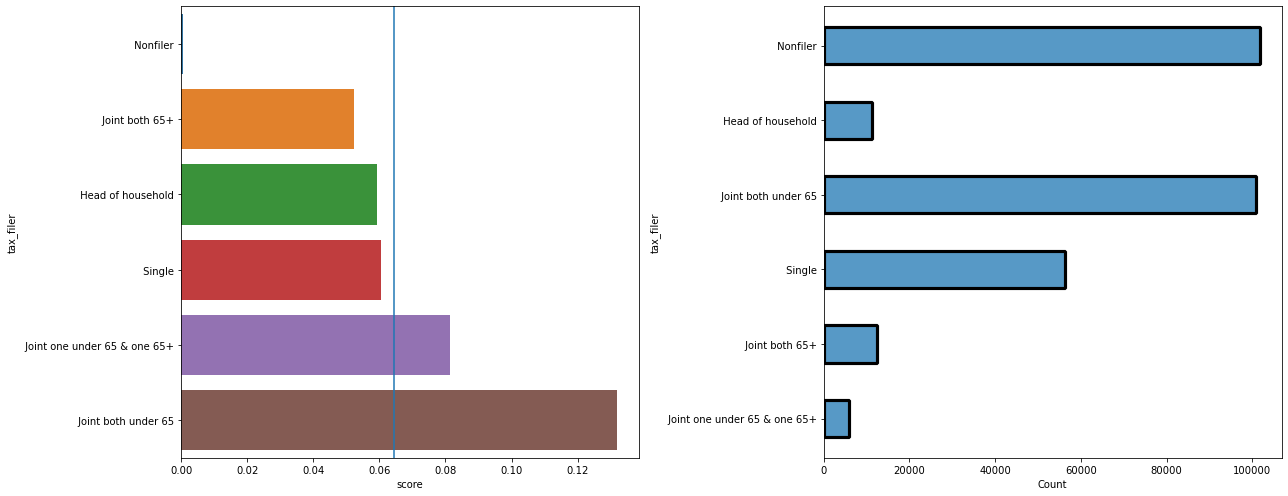

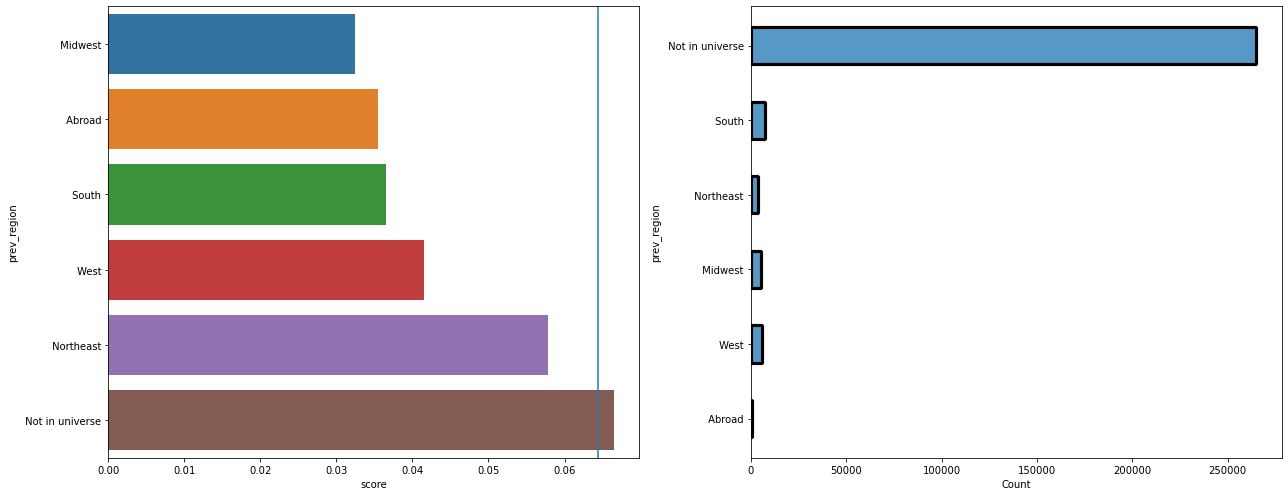

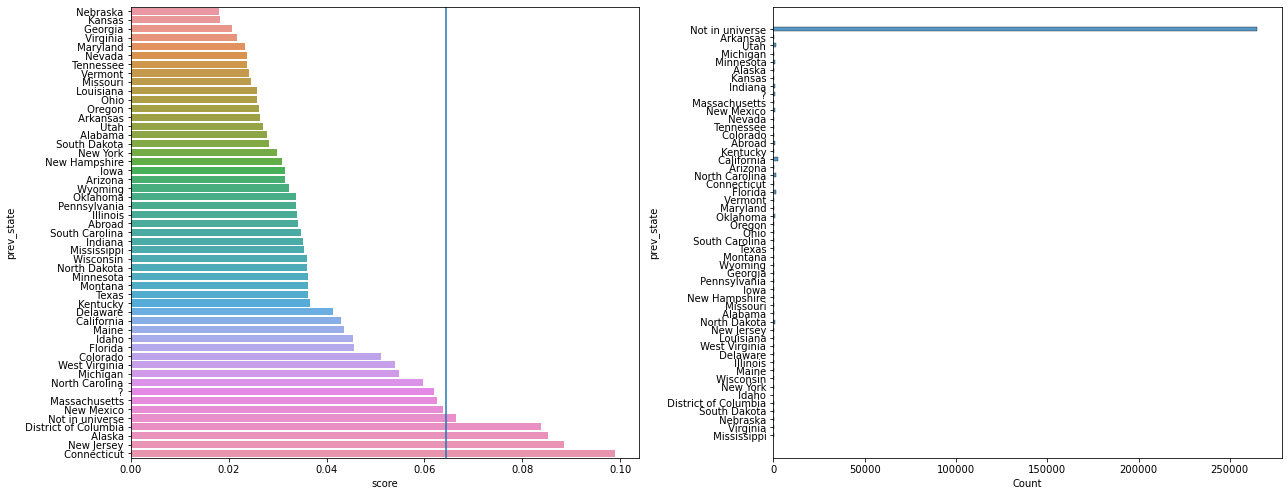

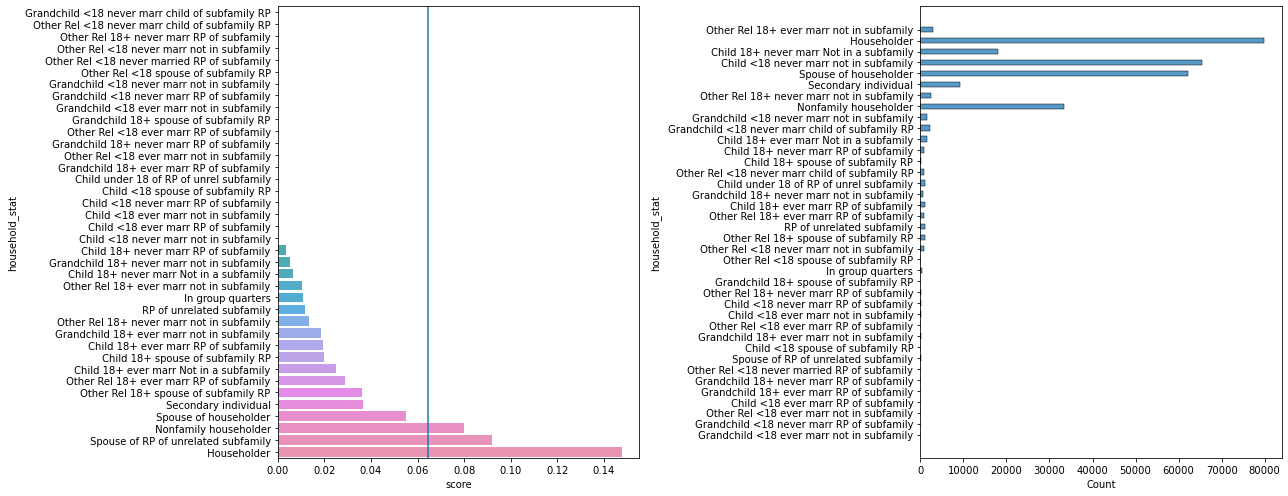

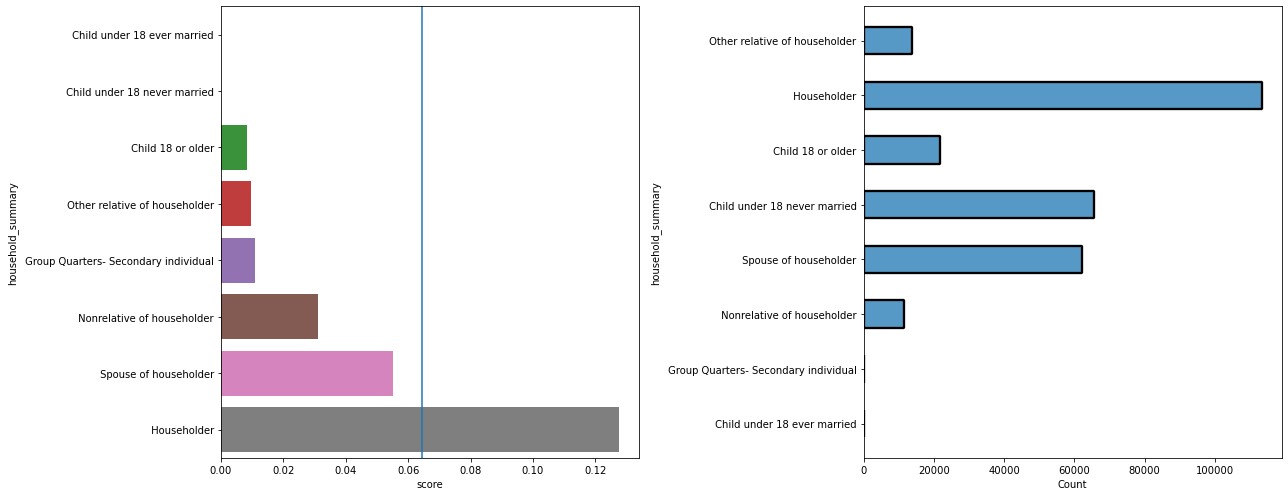

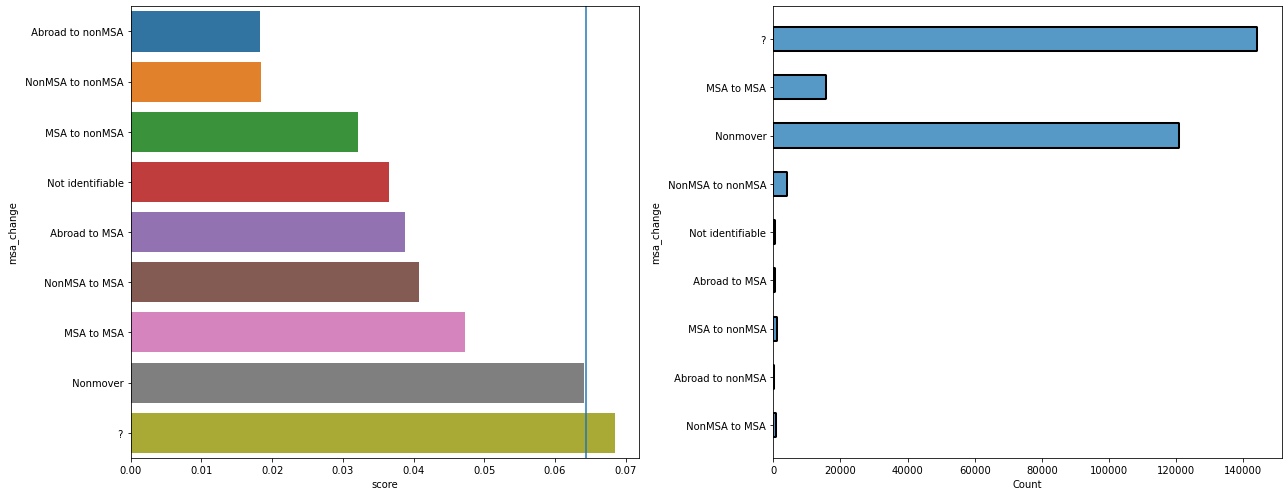

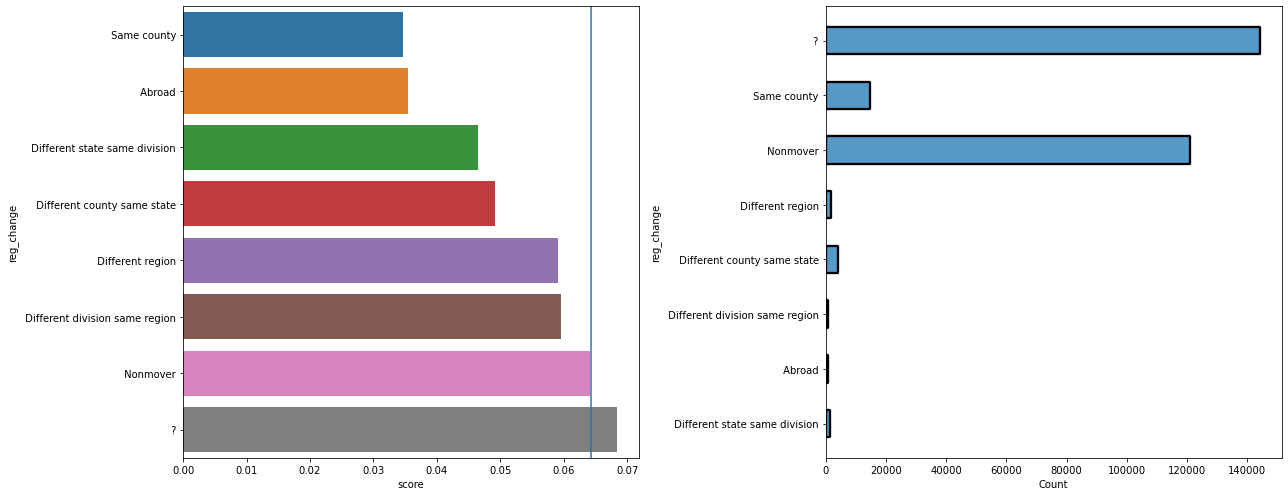

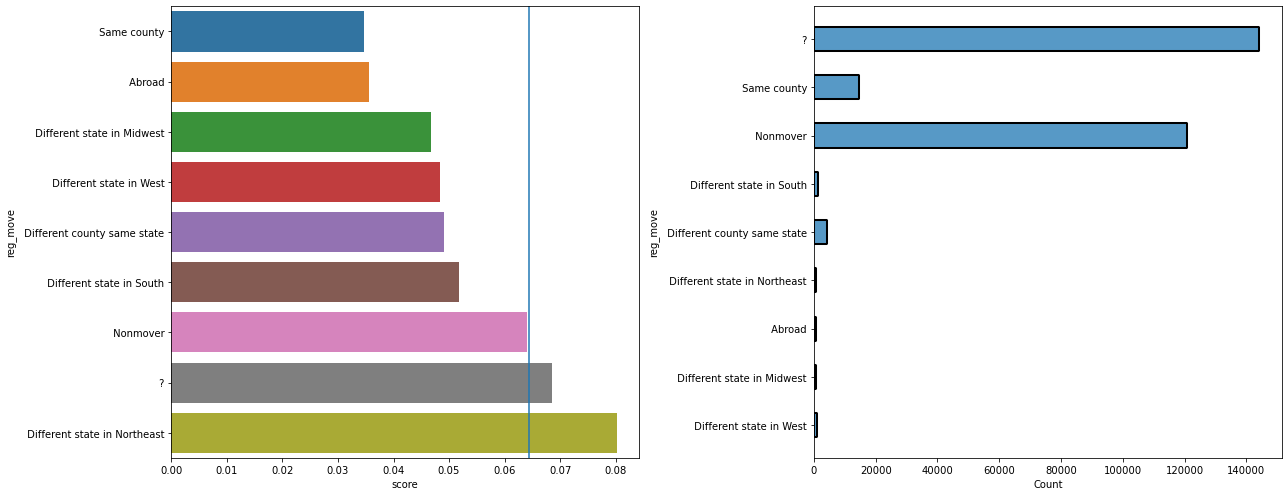

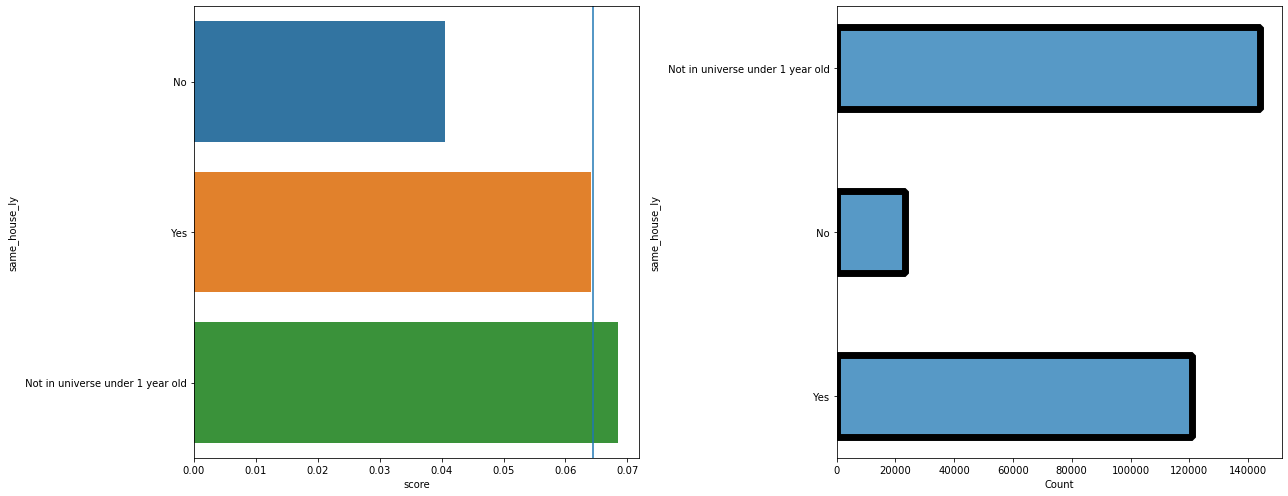

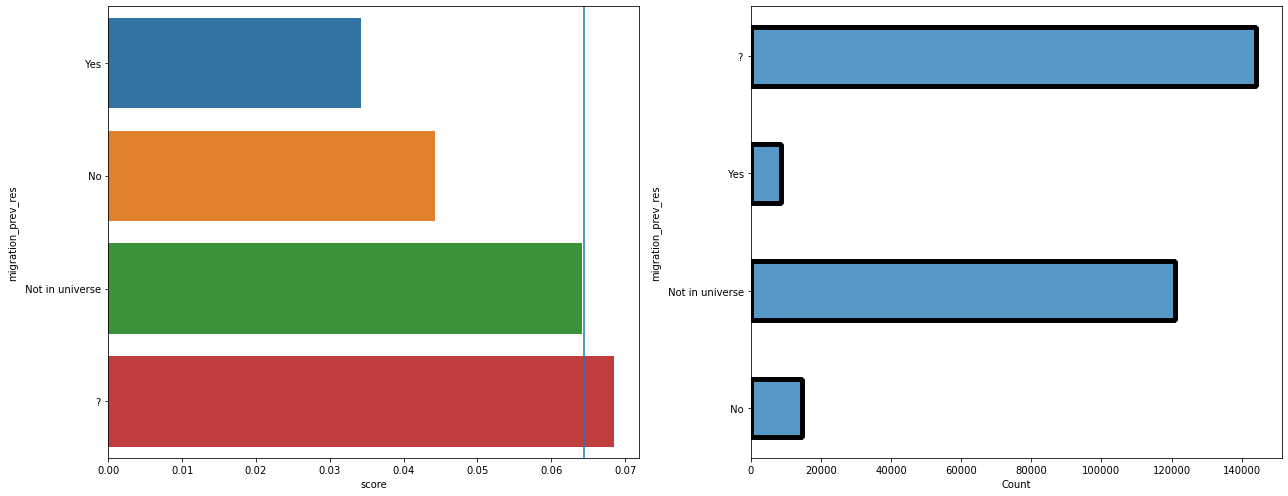

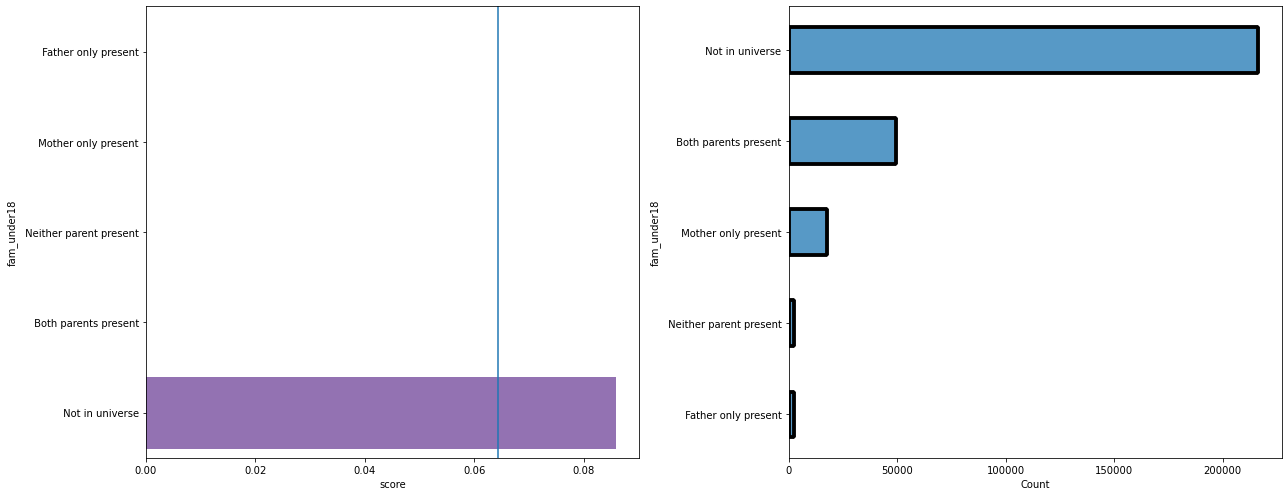

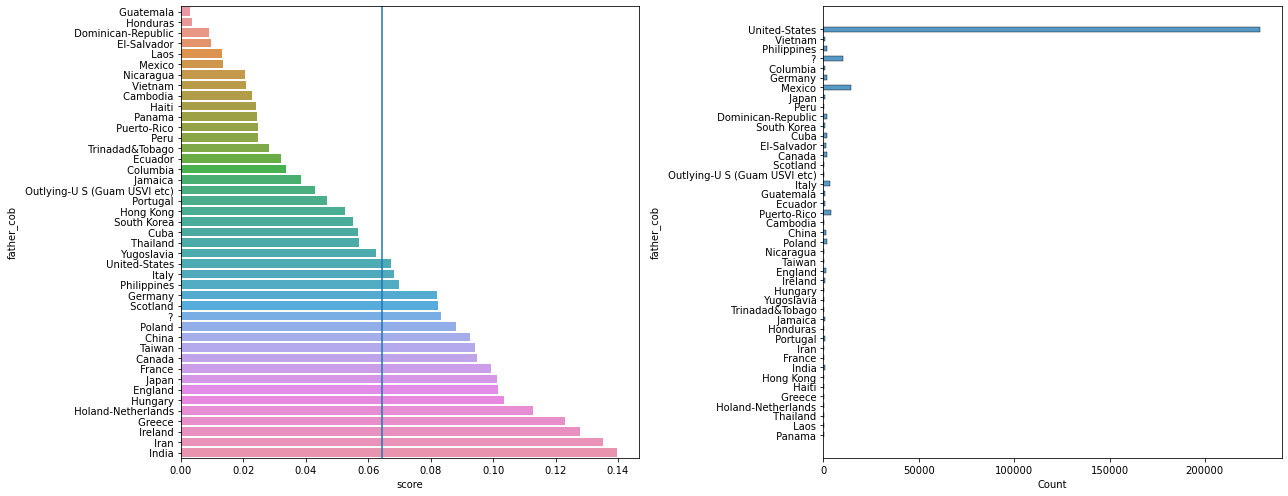

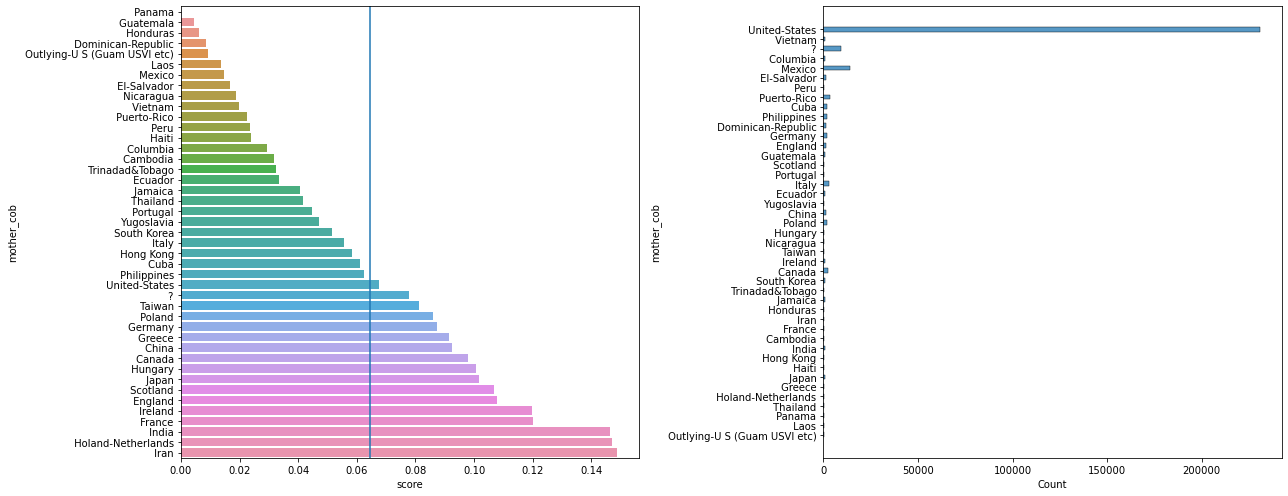

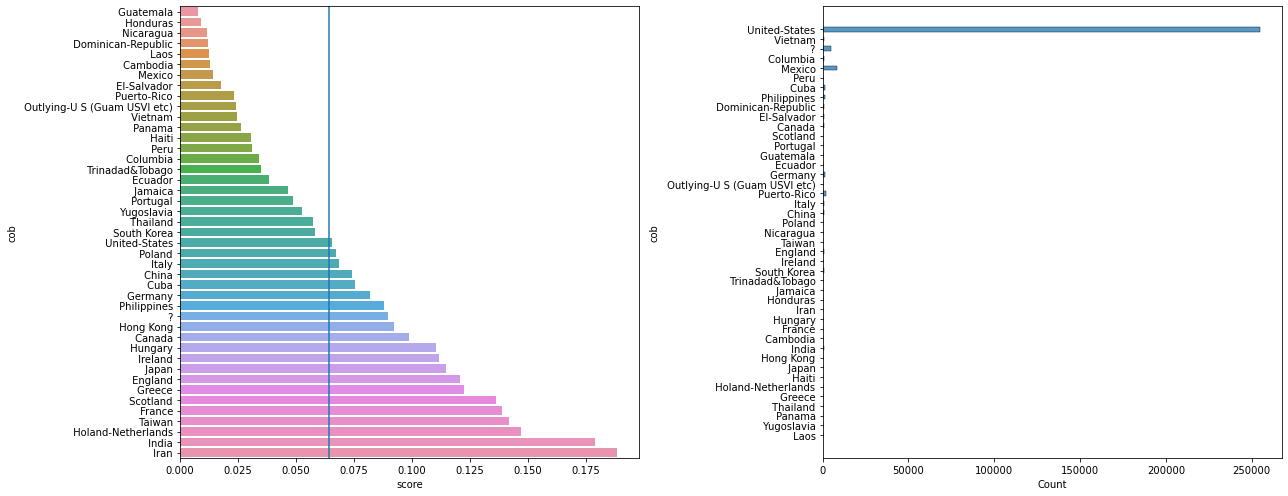

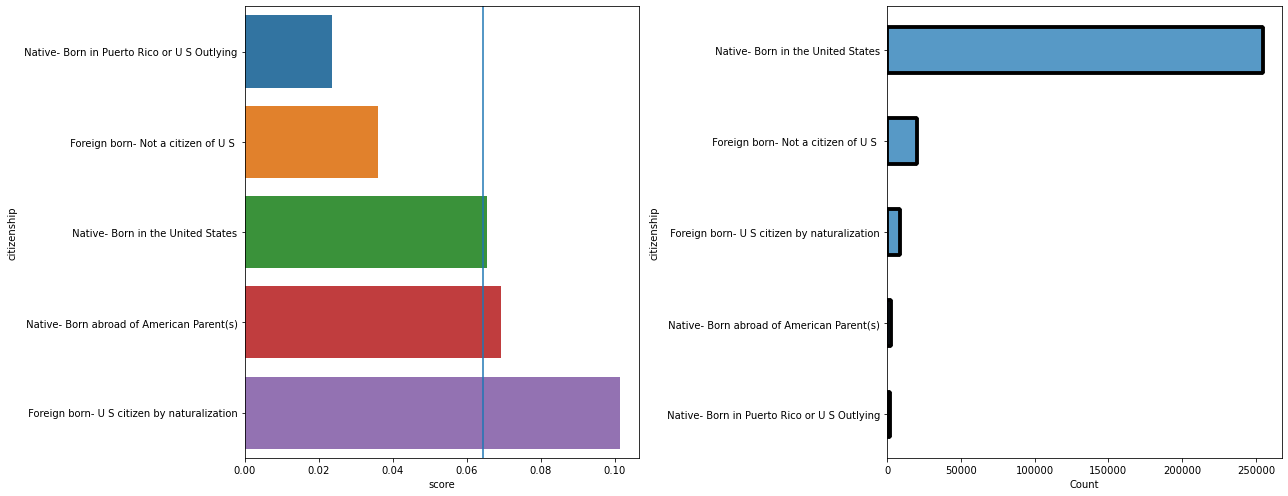

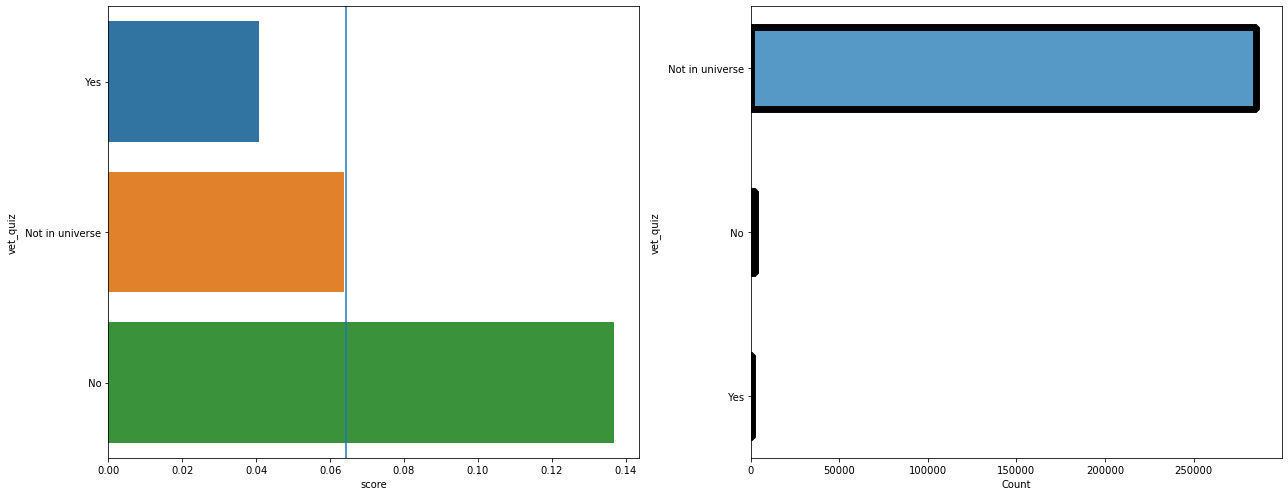

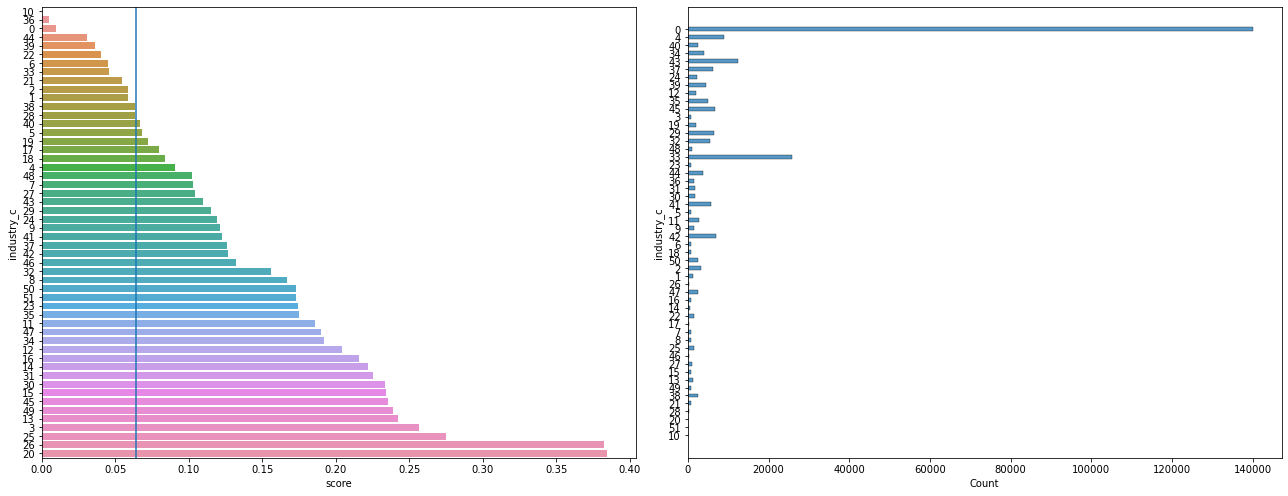

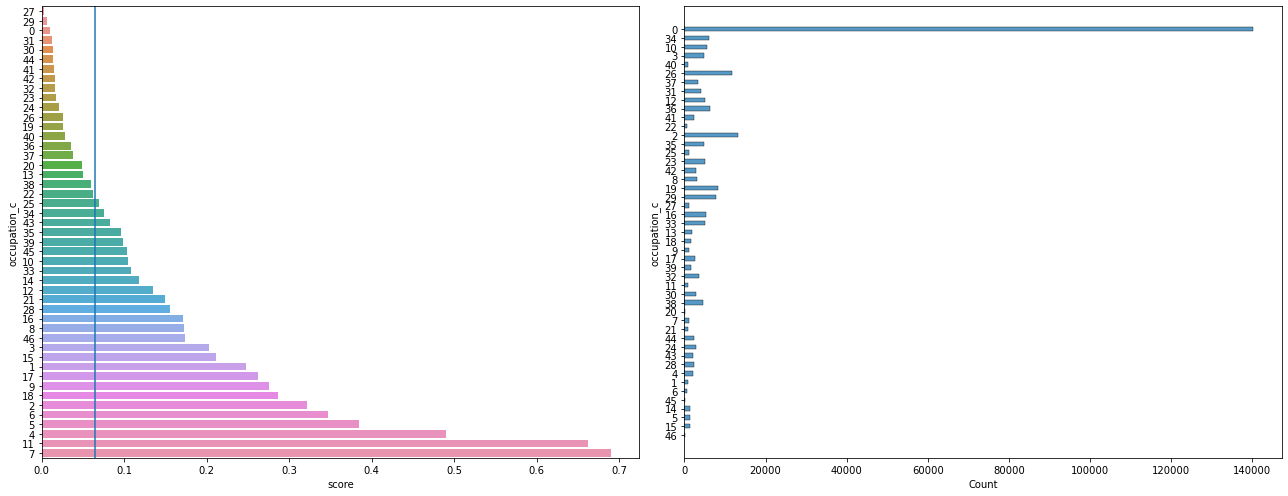

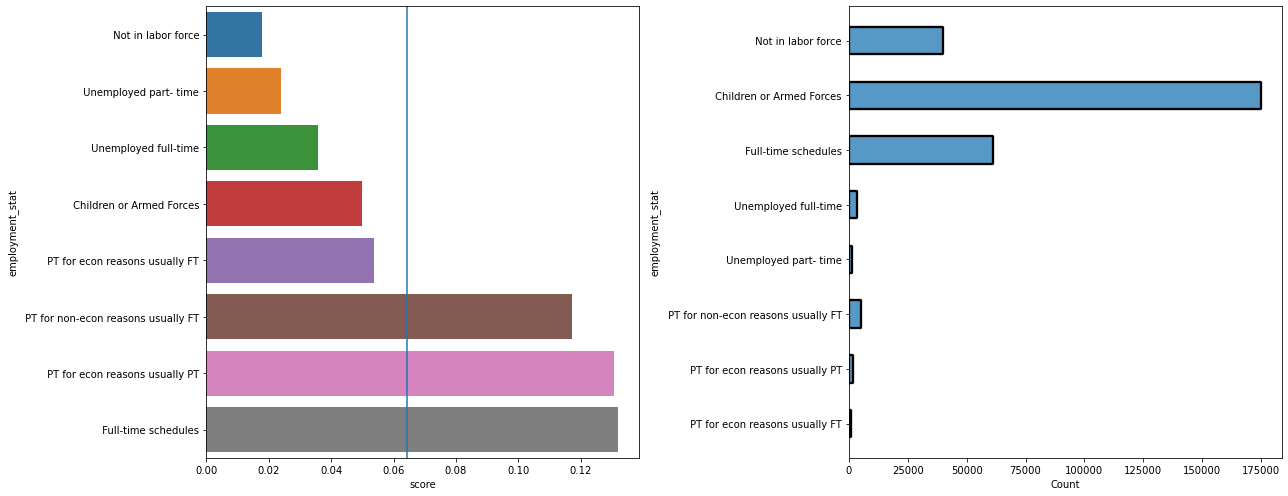

In [1533]:
qual_cols = [
    'lw_educ', 'major_industry_c', 'major_occupation_c',
    'hispanic', 'unemp_reason', 'tax_filer', 'prev_region',
    'prev_state', 'household_stat', 'household_summary',
    'msa_change', 'reg_change', 'reg_move', 'same_house_ly',
    'migration_prev_res', 'fam_under18', 'father_cob',
    'mother_cob', 'cob', 'citizenship', 'vet_quiz',
    'industry_c', 'occupation_c', 'employment_stat'
    ]

plt.rcParams.update({'figure.max_open_warning': 0})

totals = eda_data.groupby('over50k').size()
average_score = totals[1] / sum(totals)
for col in qual_cols:
    temp_data = get_income_score(eda_data, col).sort_values('score')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
    sns.barplot(ax=ax[0], data=temp_data, y=col, x='score')
    ax[0].axvline(x=average_score)
    sns.histplot(ax=ax[1], data=eda_data, y=col, shrink=.5, fill=True)
    plt.tight_layout()

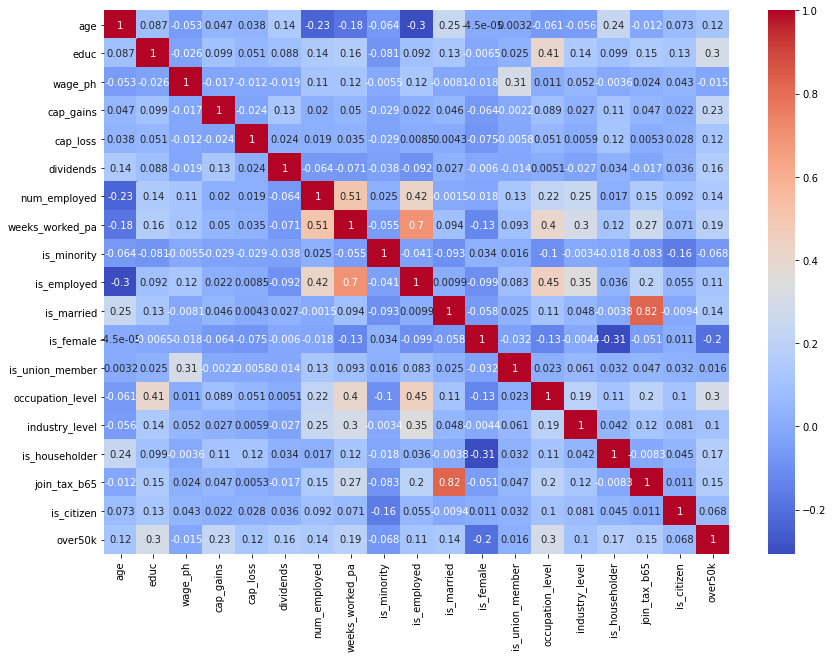

In [1534]:
plt.subplots(figsize=(14,10))
sns.heatmap(data95.corr(), cmap="coolwarm", annot=True)

In [1606]:
def eval_models(algos, X, y, X_test, y_test, alg=None):
    print("Algorithm, F1-under50k, F1-over50k, accuracy")
    if alg:
        algos = [a for a in algos if alg == a[0]]
    for name, algo in algos:
        algo.fit(X, y)
        y_prediction = algo.predict(X_test)
        cr = classification_report(y_test, y_prediction, target_names=['under50k','over50k'], output_dict=True)
        print('{}: {:.2f}, {:.2f}, {:.2f}'.format(name, cr['under50k']['f1-score'],
                cr['over50k']['f1-score'], cr['accuracy']))    

In [1608]:
def gen_params(df, drop_features=None):    
    predictors = df.columns.drop(['over50k'])
    y = df['over50k'].to_numpy()
    if drop_features:
        X = df[predictors.drop(drop_features)].to_numpy()
    else:
        X = df[predictors].to_numpy()
    return X, y

In [1556]:
cols_to_drop = ['wage_ph', 'is_minority', 'is_union_member', 'is_citizen']

X, y = gen_params(full_data)
X_94, y_94 = gen_params(data94)
X_95, y_95 = gen_params(data95)

In [1691]:
def downsample(df):
    minority = df.loc[df.over50k == 1]
    minority_n = len(minority)
    majority = df.loc[df.over50k == 0].sample(minority_n)
    return pd.concat([minority, majority])

In [1714]:
# Discrading uncorrelated features
cols_to_drop = [col for col, cor in data95.corr().over50k.to_dict().items() if abs(cor) < 0.1]

In [1735]:
algos = [
    ('GNB', GaussianNB()),
    ('XGB', XGBClassifier()),
    ('RFC', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', svm.SVC()),
]

In [1736]:
X, y = gen_params(data95, cols_to_drop)
X_test, y_test = gen_params(cook_data(test_data, numeric=True), cols_to_drop)
eval_models(algos, X, y, X_test, y_test)

Algorithm, F1-under50k, F1-over50k, accuracy
GNB, 0.94, 0.43, 0.90
XGB, 0.96, 0.56, 0.92
RFC, 0.95, 0.52, 0.91
KNN, 0.95, 0.47, 0.90
SVM, 0.95, 0.25, 0.90


In [1738]:
X, y = gen_params(full_data, cols_to_drop)
X_test, y_test = gen_params(cook_data(test_data, numeric=True), cols_to_drop)
eval_models(algos, X, y, X_test, y_test)

Algorithm, F1-under50k, F1-over50k, accuracy
GNB, 0.94, 0.42, 0.90
XGB, 0.96, 0.56, 0.92
RFC, 0.95, 0.52, 0.91
KNN, 0.95, 0.48, 0.91
SVM, 0.95, 0.26, 0.90


Using data from both years 94 and 95 does not seem to add any significant performance gain and it is likely to be panel data displaying information about the same people.

In [1737]:
X, y = gen_params(downsample(data95), cols_to_drop)
X_test, y_test = gen_params(cook_data(test_data, numeric=True), cols_to_drop)
eval_models(algos, X, y, X_test, y_test)

Algorithm, F1-under50k, F1-over50k, accuracy
GNB, 0.94, 0.50, 0.89
XGB, 0.89, 0.50, 0.82
RFC, 0.88, 0.47, 0.80
KNN, 0.83, 0.41, 0.73
SVM, 0.93, 0.38, 0.87


### Summary

Due to both testing and training datasets being severely imbalanced, the accuracy of models is inflated by the fact that the vast majority of population groups have annual incomes below $50,000. Therefore, I tried to focus on F1-score for predicting population groups with an income of over $50,000. The training dataset appears to be a panel dataset split between years 94 and 95, however, I could not find any sources to confirm this. However, filtering training set by year leads to insignificant changes in model performance.

Additionally, I have tried downsampling the training dataset and it improved results for simpler algorithms like Gaussian Naive Bayes and SVM classifier, however, it did not yield any performance increases for state-of-art classification algorithms like XGBoost and Random Forest.

Education and Occupation appear to be the most correlated features and fit intuitively as the most significant predictors. Most of the features present in the dataset are categorical, hence it also makes sense for algorithms based on decision trees to perform better. Despite that, F1-scores for predicting population groups with income over $50,000 remain very low. I did manage to achieve higher results by merging training and testing data and applying cross-validation, however for this assignment I have decided to stick to training and testing split provided.